In [1]:
import numpy as np
from numpy.random import RandomState
import pandas as pd
from scipy.stats import cauchy, gamma, norm, dirichlet,  expon
from scipy.stats import beta as beta_dist
import time
import matplotlib.pyplot as plt

In [2]:
def prior(n, hyper):
    X_1 = beta_dist.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta_dist.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def genParam(n, randomstate):
    r = RandomState(seed=randomstate)
    alpha = r.exponential(1, (n, 3))
    ksi = np.abs(r.standard_cauchy(2))
    beta = [r.dirichlet(alpha[0])]
    for i in range(1, n):
        betai = [r.dirichlet(alpha[i])]
        beta = np.concatenate((beta, betai), axis=0)
    mu = [[beta[0][0] - beta[0][1], 2 * (beta[0][0] + beta[0][1]) - 1]]
    for i in range(1, n):
        mui = [[beta[i][0] - beta[i][1], 2 * (beta[i][0] + beta[i][1]) - 1]]
        mu = np.concatenate((mu, mui), axis=0)
    sigma = r.wald(ksi[0], ksi[1], n)
    return alpha, ksi, beta, mu, sigma

def genX(n, T, mu, sigma):
    X = []
    for i in range(n):
        if mu[i][0] < T and mu[i][0] <= T + 2 and mu[i][1] < T and mu[i][1] <= T + 2:
            A = np.eye(T, T + 2) + mu[i][0] * np.eye(T, T + 2, 1) + mu[i][1] * np.eye(T, T + 2, 2)
            A = A @ A.T
            Xi = np.random.multivariate_normal(np.zeros(T), sigma[i] * A)
            X.append(Xi)
        else:
            print(f"Indices non valides pour mu[{i}]: {mu[i][0]}, {mu[i][1]}")
    return np.array(X)

def distautcor(Z, X):
    min_length = min(len(Z), len(X))
    Z = Z[:min_length]
    X = X[:min_length]
    
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)


In [29]:
def ABCbas(X, N, T, mu, sigma, eps_estimate):
    distances = []
    for i in range(N):
        simulated_X = genX(1, T, [mu], [sigma])  
        distance = distautcor(X.flatten(), simulated_X.flatten())
        distances.append((distance, mu, sigma))
    min_distance_index = np.argmin([d[0] for d in distances])
    if len(distances) > 0:
        eps_estimate = np.median(np.abs(distances[min_distance_index][0] - distances))
    return distances[min_distance_index][1], distances[min_distance_index][2], eps_estimate

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Eviter la division par 0
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])

def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = expon.rvs(size=(L, 3))  
    dist = np.zeros(L)
    for i in range(L):
        U = prior(len(Q1), hyper[i]) 
        dist[i] = np.sum((statdir(U) - statdir(Q))**2)
    return hyper[np.argmin(dist)]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N, T):
    dist = np.zeros(N)
    w = np.arange(1, min(Dat.shape[0], 10))
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        simulated_data = genX(1, T, np.array([[parh1[j], parh2[j]]]), np.array([si[i]]))
        if j >= Dat.shape[1]:
            raise IndexError(f"Index {j} is out of bounds for axis 1 with size {Dat.shape[1]}")
        valid_w = w[w < Dat.shape[0]] 
        if len(valid_w) == 0:
            raise ValueError("No valid indices in w for accessing Dat.")
        dist[i] = np.abs(np.var(simulated_data.flatten()[valid_w]) - np.var(Dat[valid_w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    pri = np.abs(cauchy.rvs(size=(Q, 2)))
    for i in range(Q):
        h = pri[i]
        y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist)]

In [19]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    # Initialiser les paramètres et les hyperparamètres
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()
    etapes_realisees = 0 
    eps = float('inf')  # Initialiser epsilon à l'infini

    results = {
        "Hyperparamètres": [],
        "Hypersigma": []
    }
    
    for iteration in range(Npts):
        # Vérifier si le temps maximum est dépassé
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break  # Sortir de la boucle principale si le temps maximum est atteint

        # Mise à jour de chaque paramètre à l'aide d'ABCbas
        for j in range(n):
            mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])
            mu[j] = mu_best
            sigma[j] = sigma_best
        
        # Mise à jour des hyperparamètres à l'aide d'ABChaut 
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        # Mise à jour du sigma à l'aide d'ABCsigm pour chaque trajectoire
        for j in range(n):
            sigma[j], _, eps_estimate = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T, eps_estimate)
        
        # Mise à jour de l'hypersigma en utilisant ABCsigmhaut
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        # Stocker les résultats
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)
        
        
    return results

In [30]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    # Initialiser les paramètres et les hyperparamètres
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()
    etapes_realisees = 0 
    eps = float('inf')  # Initialiser epsilon à l'infini

    results = {
        "Hyperparamètres": [],
        "Hypersigma": []
    }
    
    for iteration in range(Npts):
        # Vérifier si le temps maximum est dépassé
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break  # Sortir de la boucle principale si le temps maximum est atteint

        # Mise à jour de chaque paramètre à l'aide d'ABCbas
        for j in range(n):
            mu_best, sigma_best, eps_estimate_j = ABCbas(X[:, j], N, T, mu[j], sigma[j], objectifeps)
            mu[j] = mu_best
            sigma[j] = sigma_best
            eps_estimate = np.min([eps_estimate, eps_estimate_j])
        
        # Mise à jour des hyperparamètres à l'aide d'ABChaut 
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        # Mise à jour du sigma à l'aide d'ABCsigm pour chaque trajectoire
        for j in range(n):
            sigma_j, _, eps_estimate_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T, eps_estimate)
            sigma[j] = sigma_j
            eps_estimate = np.min([eps_estimate, eps_estimate_j])
        
        # Mise à jour de l'hypersigma en utilisant ABCsigmhaut
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        # Stocker les résultats
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)
        
    return results

In [31]:
N = 100  # Nombre de simulations pour les paramètres
M = 100  # Nombre de simulations pour l'hyperparamètre
P = 100  # Nombre de simulations pour sigma
P2 = 100  # Nombre de simulations pour hypersigma
Npts = 1000 # Nombre total d'itérations de l'algorithme global

n = 5 #Nombre de trajectoires dans les données d'entrée
T = 30 # Longueur des trajectoires dans les données d'entrée

objectifeps = 0.1  # Seuil de niveau d'erreur entre les données simulées et les données observées
temps_max = 30   # Temps d'éxecution maximum de l'algorithme global en secondes

alpha, ksi, beta, mu, sigma=genParam(n, randomstate=0)
X=genX(n, T, mu, sigma)

hyper_real= [1,2,3]
hypersigm_real= [1,1]

In [32]:
resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
resultats

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (100, 3) + inhomogeneous part.

In [ ]:
def distance(resultats, hyper_real, hypersigm_real):

    hyper_real=np.array(hyper_real)
    hypersigm_real=np.array(hypersigm_real)

    hyper_estime = resultats["Hyperparamètres"]
    hypersigm_estime = resultats["Hypersigma"]

    dist_eucli_hyper= np.sqrt(np.sum((hyper_estime - hyper_real) ** 2, axis=1))
    dist_eucli_hypersigm= np.sqrt(np.sum((hypersigm_estime - hypersigm_real) ** 2, axis=1))
    
    # Calculer les distances euclidiennes
    distance_hyper = np.mean(dist_eucli_hyper)
    distance_hypersigm = np.mean(dist_eucli_hypersigm)

    # Retourner les distances dans un dictionnaire
    return {
        'Distance Hyperparamètre': distance_hyper,
        'Distance Hypersigma': distance_hypersigm
    }

In [ ]:
temps_max_values = range(30, 160, 30) 
standard_error_hyper = []
standard_error_hypersigma = []
distance_hyper = []
distance_hypersigm = []

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hyper = np.std(hyper)
    std_hypersigma = np.std(hypersigma)
    standard_error_hyper.append(std_hyper)
    standard_error_hypersigma.append(std_hypersigma)

    dist = distance(resultats, hyper_real, hypersigm_real)
    dist_hyper=dist['Distance Hyperparamètre']
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hyper.append(dist_hyper)
    distance_hypersigm.append(dist_hypersigm)

C:\Users\sarah\AppData\Local\Temp\ipykernel_1652\3361079472.py:13: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_1652\3361079472.py:21: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_1652\3054455161.py:22: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Xi = np.random.multivariate_normal(np.zeros(T), sigma[i] * A)
C:\Users\sarah\AppData\Local\Temp\ipykernel_1652\3361079472.py:44: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 30 secondes atteint à la 5ème itération.
Temps maximum d'exécution de 60 secondes atteint à la 7ème itération.


KeyboardInterrupt: 

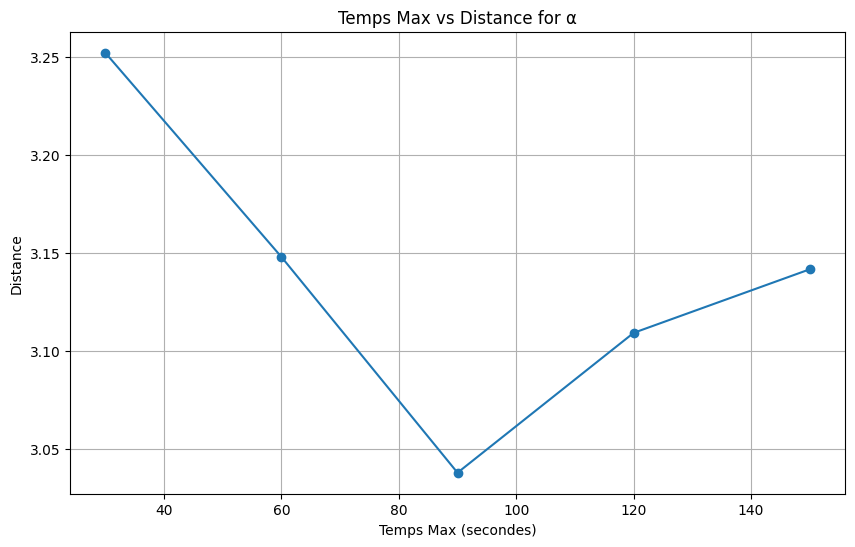

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hyper,  marker='o', linestyle='-')
plt.title('Temps Max vs Distance for α')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

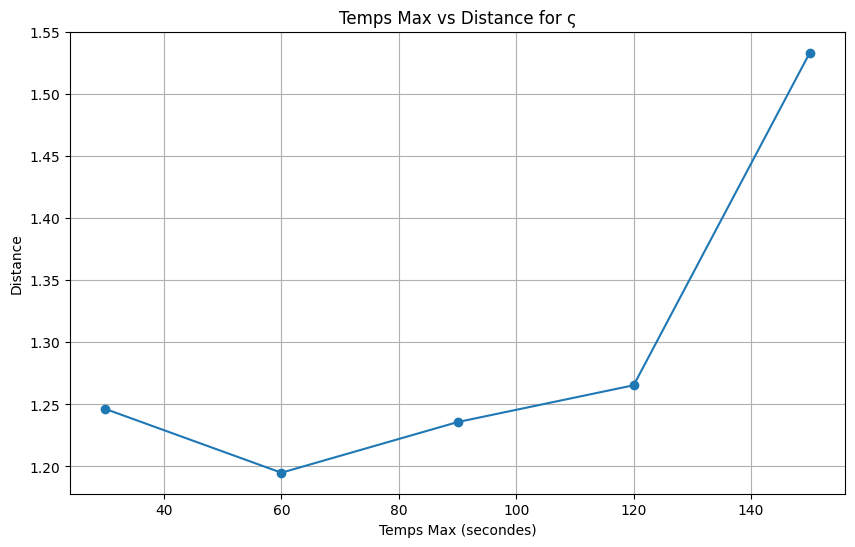

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm, marker='o', linestyle='-')
plt.title('Temps Max vs Distance for ς')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

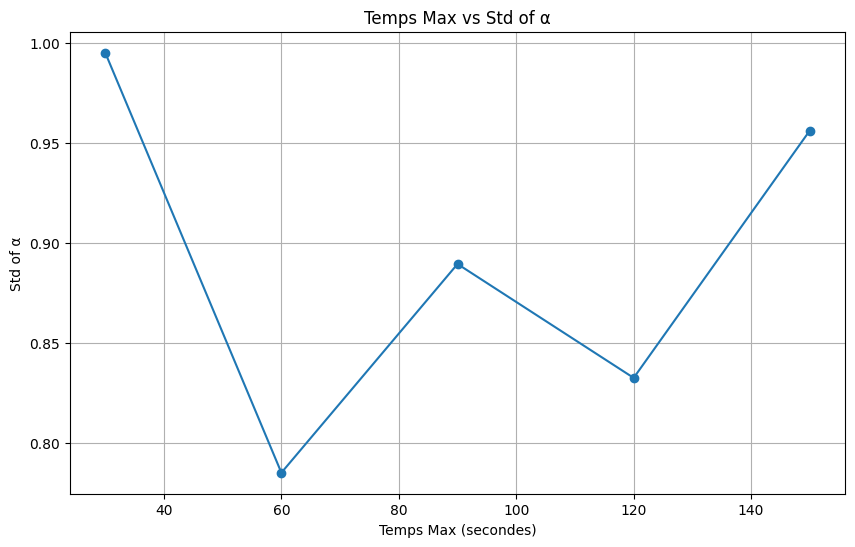

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, standard_error_hyper, marker='o', linestyle='-')
plt.title('Temps Max vs Std of α')
plt.ylabel('Std of α')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

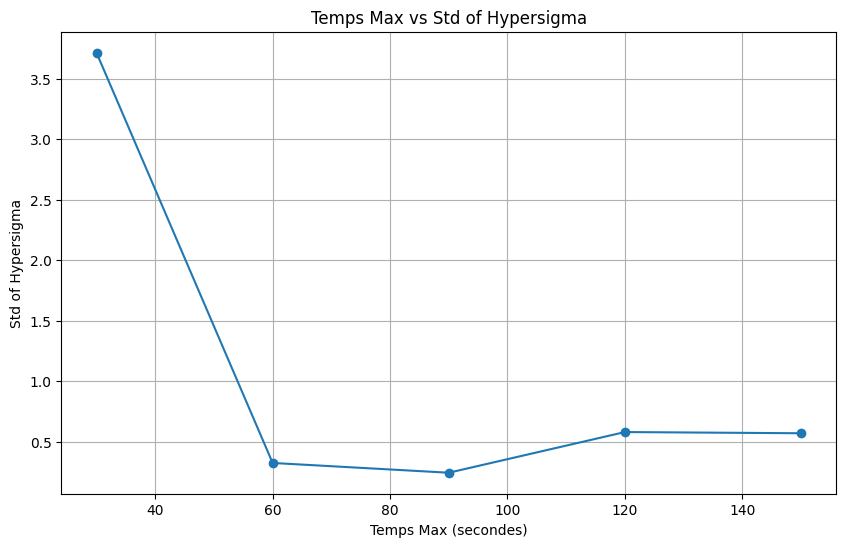

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, standard_error_hypersigma, marker='o', linestyle='-')
plt.title('Temps Max vs Std of ς')
plt.ylabel('Std of ς')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()